# Ансамбли моделей машинного обучения.

#### Цель лабораторной работы:

Изучение ансамблей моделей машинного обучения.

### Задание:



    1) Выберите набор данных (датасет) для решения задачи классификации или регресии.

    2) В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

    3) С использованием метода train_test_split разделите выборку на обучающую и тестовую.

    4) Обучите следующие ансамблевые модели:
        одну из моделей группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
        одну из моделей группы бустинга;
        одну из моделей группы стекинга.

    5) (+1 балл на экзамене) Дополнительно к указанным моделям обучите еще две модели:
        Модель многослойного персептрона. По желанию, вместо библиотеки scikit-learn возможно использование библиотек TensorFlow, PyTorch или других аналогичных библиотек.
        Модель МГУА с использованием библиотеки - https://github.com/kvoyager/GmdhPy (или аналогичных библиотек). Найдите такие параметры запуска модели, при которых она будет по крайней мере не хуже, чем одна из предыдущих ансамблевых моделей.

    6) Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.


## 1) Выберите набор данных (датасет) для решения задачи классификации или регрессии.    

### Импорт библиотек

In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import load_iris, load_boston
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 


from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset





%matplotlib inline 
sns.set(style="ticks")

# скроем предупреждения о возможных ошибках для лучшей читаемости
import warnings
warnings.filterwarnings('ignore')

### Смотрим на датасет

In [108]:
data = pd.read_csv('./diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [109]:
df = data.sample(n=1000)

In [110]:
df['Diabetes_binary'].value_counts()

0.0    512
1.0    488
Name: Diabetes_binary, dtype: int64

In [111]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
48517,1.0,1.0,1.0,1.0,28.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,0.0,10.0,1.0,1.0,7.0,5.0,8.0
11802,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,30.0,0.0,0.0,10.0,5.0,8.0
21240,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,9.0,6.0,7.0
37875,1.0,1.0,0.0,1.0,34.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,7.0
47960,1.0,1.0,1.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,13.0,4.0,5.0


In [112]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,0.488000,0.571000,0.511000,0.975000,30.335000,0.475000,0.069000,0.143000,0.718000,0.616000,...,0.948000,0.104000,2.833000,4.088000,6.184000,0.255000,0.45500,8.345000,4.956000,5.74500
std,0.500106,0.495181,0.500129,0.156203,7.180692,0.499624,0.253581,0.350248,0.450198,0.486601,...,0.222138,0.305413,1.102872,8.526133,10.328544,0.436079,0.49822,2.931991,1.017398,2.16302
min,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.00000
25%,0.000000,0.000000,0.000000,1.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,6.000000,4.000000,4.00000
50%,0.000000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,9.000000,5.000000,6.00000
75%,1.000000,1.000000,1.000000,1.000000,34.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,3.000000,7.000000,1.000000,1.00000,10.000000,6.000000,8.00000
max,1.000000,1.000000,1.000000,1.000000,84.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.00000,13.000000,6.000000,8.00000


In [113]:
print("Размер набора:")
print(f'В датасете {df.shape[0]} строк и {df.shape[1]} колонок.')

Размер набора:
В датасете 1000 строк и 22 колонок.


In [114]:
df.dtypes

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

In [115]:
df.astype('int').dtypes

Diabetes_binary         int32
HighBP                  int32
HighChol                int32
CholCheck               int32
BMI                     int32
Smoker                  int32
Stroke                  int32
HeartDiseaseorAttack    int32
PhysActivity            int32
Fruits                  int32
Veggies                 int32
HvyAlcoholConsump       int32
AnyHealthcare           int32
NoDocbcCost             int32
GenHlth                 int32
MentHlth                int32
PhysHlth                int32
DiffWalk                int32
Sex                     int32
Age                     int32
Education               int32
Income                  int32
dtype: object

## 2) В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

### Не нужно

## 3) С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [116]:
X = df.drop('Diabetes_binary', axis=1)
Y = df['Diabetes_binary']

In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(700, 21), (300, 21)
(700,), (300,)


## 4) Обучите следующие ансамблевые модели:

Cлучайный лес

Бустинг

Стекинг

In [118]:
RFC = RandomForestClassifier()
RFC.fit(X_train, Y_train)

RandomForestClassifier()

In [119]:
My_KNN_target_1_0 = RFC.predict(X_train)
My_KNN_Y_Pred = RFC.predict(X_test)
print(f'Accuracy:',     accuracy_score(Y_train,My_KNN_target_1_0),      accuracy_score(Y_test,My_KNN_Y_Pred))
print(f'Precision:',    precision_score(Y_train,My_KNN_target_1_0),     precision_score(Y_test,My_KNN_Y_Pred))
print(f'F1:',           f1_score(Y_train,My_KNN_target_1_0),            f1_score(Y_test,My_KNN_Y_Pred))
print(f'Recall:',       recall_score(Y_train,My_KNN_target_1_0),        recall_score(Y_test,My_KNN_Y_Pred))

Accuracy: 1.0 0.7366666666666667
Precision: 1.0 0.7039473684210527
F1: 1.0 0.7303754266211605
Recall: 1.0 0.7588652482269503


In [120]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), X, Y, cv=4, scoring='accuracy')
scores

array([0.66 , 0.652, 0.596, 0.628])

In [121]:
np.mean(scores)

0.634

In [122]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train, Y_train)

GradientBoostingClassifier()

In [123]:
My_KNN_target_1_0 = GBC.predict(X_train)
My_KNN_Y_Pred = GBC.predict(X_test)
print(f'Accuracy:',     accuracy_score(Y_train,My_KNN_target_1_0),      accuracy_score(Y_test,My_KNN_Y_Pred))
print(f'Precision:',    precision_score(Y_train,My_KNN_target_1_0),     precision_score(Y_test,My_KNN_Y_Pred))
print(f'F1:',           f1_score(Y_train,My_KNN_target_1_0),            f1_score(Y_test,My_KNN_Y_Pred))
print(f'Recall:',       recall_score(Y_train,My_KNN_target_1_0),        recall_score(Y_test,My_KNN_Y_Pred))

Accuracy: 0.8757142857142857 0.7633333333333333
Precision: 0.8611111111111112 0.7333333333333333
F1: 0.8769448373408769 0.7560137457044672
Recall: 0.8933717579250721 0.7801418439716312


In [124]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), X, Y, cv=4, scoring='accuracy')
scores

array([0.66 , 0.652, 0.596, 0.628])

In [125]:
np.mean(scores)

0.634

#### Стекинг

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(700, 21), (300, 21)
(700,), (300,)


In [127]:
# Точность на отдельных моделях
for model in [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

Accuracy: 0.8757142857142857 0.7633333333333333
Precision: 0.8611111111111112 0.7333333333333333
F1: 0.8769448373408769 0.7560137457044672
Recall: 0.8933717579250721 0.7801418439716312
LogisticRegression()
MAE=0.23666666666666666

Accuracy: 0.8757142857142857 0.7633333333333333
Precision: 0.8611111111111112 0.7333333333333333
F1: 0.8769448373408769 0.7560137457044672
Recall: 0.8933717579250721 0.7801418439716312
DecisionTreeClassifier()
MAE=0.23666666666666666

Accuracy: 0.8757142857142857 0.7633333333333333
Precision: 0.8611111111111112 0.7333333333333333
F1: 0.8769448373408769 0.7560137457044672
Recall: 0.8933717579250721 0.7801418439716312
RandomForestClassifier(n_estimators=50)
MAE=0.23666666666666666



In [128]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=3, n_jobs=-1, error_score='raise')
	return scores

>lr 0.746 (0.025)
>knn 0.674 (0.013)
>cart 0.649 (0.015)
>svm 0.710 (0.006)
>bayes 0.731 (0.021)
>stacking 0.739 (0.026)


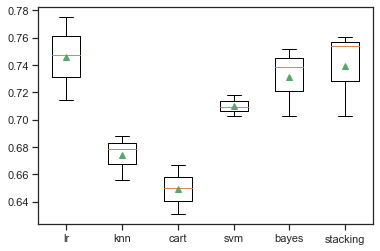

In [129]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()